## Proceso de analisis exploratorio de datos (EDA)

<big> * ETL </big>

Los datos iniciales tomados para este proyecto se dividen en dos archivos las películas **[movies]** y los créditos de cada película **[credits]**, cada archivo tiene más de 45,000 entradas.

En cada entrada de los datos en películas se repite innecesariamente los detalles de los lenguajes, los géneros, las colecciones, las compañías que las producen y los países en los que se producen.

En cada entrada de los créditos pueden o no repetirse la información característica de cada actor o miembro del casting y de cada miembro de la producción o empleado en las columnas crew.

En el caso de las películas lo primero que debe realizarse es una separación de los datos característicos repetidos en las dichas columnas para eso se ha decidido separar el Dataset en archivos separados, específicos para cada colección, compañía, países, géneros, lenguajes, directores y miembros del casting, tomadas como información específica para soluciones solicitadas en este mvp y como posibles features para el modelo de recomendación. 
<small> 

__Una vez separados los datos, hemos logramos reducir el tamaño de los Data sets de interés, es decir, de películas y créditos, siendo este último directamente separado en los dos sets de interés, el casting y los directores, estos tienen la información del ID de las películas en las que aparecen o dirigen.__

</small>

In [125]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt

In [126]:
movies = pd.read_csv("datasets/movies.csv", index_col="id")

In [127]:
cast = pd.read_csv("datasets/cast.csv", index_col="id")

In [128]:
direc = pd.read_csv("datasets/directors.csv", index_col="id")

<big> * Analisis </big>

Para iniciar este análisis debo encontrar similitudes entre las películas que puedan formar un algoritmo de machine learning que no recomiende películas en base a un título inicial, asumiendo qué queremos que nuestras recomendaciones se basen en la similitud del resto de películas a nuestra película elegida.

Para obtener esta similitud tenemos, el dataset de películas, distintas características que funcionan como buenas candidatas para asimilar las películas, siendo:
<small>

el **budget**, **revenue**, los **géneros**, los **lenguajes** (tanto originales como hablados), la **popularidad**, las **compañías** que las producen, los **países** en las que se producen, el **tiempo de duración** de la película, el **retorno** que produjo la película, el **año** en el que se produjo, los **votos** que recibió, y el **promedio de votos**.
</small>

In [129]:
movies = movies[["popularity", "budget", "revenue", "return", "vote_count", "vote_average", "release_year", "spoken_languages", "original_language", "runtime", "belongs_to_collection", "production_companies", "production_countries", "genres"]]
movies.shape

(45376, 14)

Dado que el objetivo inicial es reducir el tamaño del dataset se puede empezar con el candidato más obvio para reducir, en orden de relevancia, siendo este la **popularidad**.

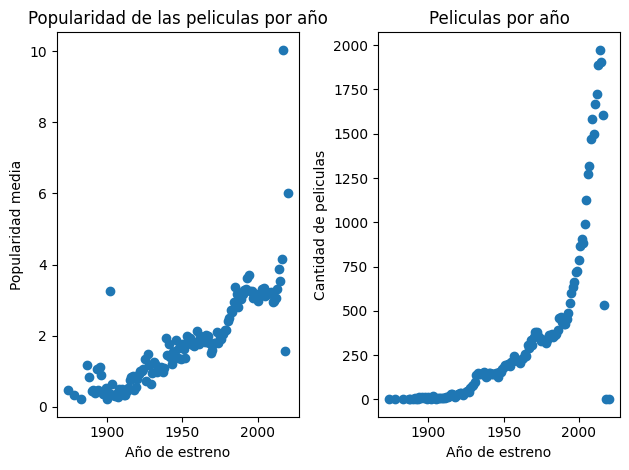

In [130]:
popularity_by_years = movies.groupby('release_year')['popularity'].mean()

plt.subplot(1,2,1)
plt.scatter(popularity_by_years.index, popularity_by_years.values)

plt.xlabel('Año de estreno')
plt.ylabel('Popularidad media')
plt.title('Popularidad de las peliculas por año')

movies_by_year = movies.groupby("release_year")["popularity"].count()
plt.subplot(1,2,2)
plt.scatter(movies_by_year.index, movies_by_year.values)


plt.xlabel('Año de estreno')
plt.ylabel('Cantidad de peliculas')
plt.title('Peliculas por año')

plt.tight_layout()

- De esto deducimos que las peliculas mas antiguas son menos y menos populares 

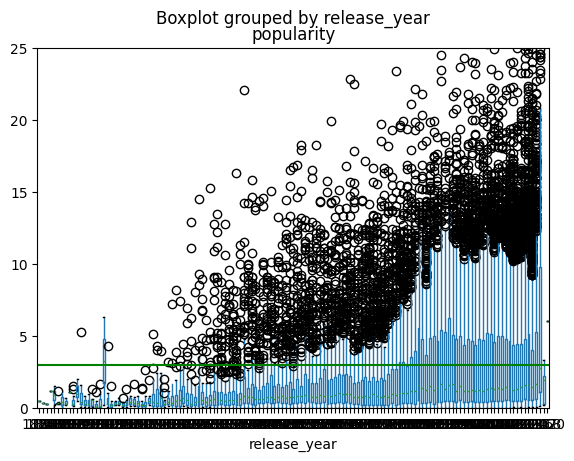

In [131]:
popularity_groups_by_years = movies[["release_year", "popularity"]]
pt = popularity_groups_by_years.boxplot(by ='release_year', column =['popularity'], grid = False)
pt.set_ylim(0,25)
pt.axhline(popularity_groups_by_years["popularity"].mean(), color="green")

Puedo definir entonces, como objetivo, aquellas peliculas sobresalientes en popularidad o que son de tiempos modernos y medianamente conocidas, lo que puede verse dividido a partir de aquellas filmaciones con una **popularidad aproximadamente mayor a la media**, lo que podriamos definir como '<small>_peliculas exitosas_</small>'

In [132]:
filtered_movies = movies[movies["popularity"]>movies["popularity"].mean()]
filtered_movies[["belongs_to_collection", "vote_count"]] =filtered_movies[["belongs_to_collection", "vote_count"]].astype("Int64") 
# filtered_movies.to_csv("datasets/movies_final.csv") only having all columns
filtered_movies.shape # this filter correspondes to movie_final.csv

C:\Users\Jorge Schimpf\AppData\Local\Temp\ipykernel_1224\1814818523.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_movies[["belongs_to_collection", "vote_count"]] =filtered_movies[["belongs_to_collection", "vote_count"]].astype("Int64")


(13051, 14)

pasamos así de **45376** entradas a **13051**

In [133]:
movies = filtered_movies

Una vez reducido el dataset inicial se puede graficar las relaciones entre la popularidad de una filmación y el promedio de sus votos, la cantidad de votos, el retorno, los géneros, los lenguajes, las compañías, los países y el tiempo de duración.

In [134]:
import ast

In [135]:
pop_by_gender = movies["genres"].apply(ast.literal_eval)

genres = []
for gl in pop_by_gender.values:
    for g in gl:
        if g not in genres:
            genres.append(g)


In [136]:
df_genres = movies[["popularity", "vote_count", "vote_average", "budget", "revenue", "return", "runtime"]]
df_genres["genres"] = pop_by_gender
for g in genres:
    df_genres[g] = 0

C:\Users\Jorge Schimpf\AppData\Local\Temp\ipykernel_1224\1877870618.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genres["genres"] = pop_by_gender
C:\Users\Jorge Schimpf\AppData\Local\Temp\ipykernel_1224\1877870618.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genres[g] = 0
C:\Users\Jorge Schimpf\AppData\Local\Temp\ipykernel_1224\1877870618.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [137]:
for i, row in df_genres.iterrows():
    for g in row["genres"]:
        df_genres.loc[i,g] = 1

In [138]:
df_genres.head(1)

,popularity,vote_count,vote_average,budget,revenue,return,runtime,genres,16,35,...,27,36,878,9648,10752,10402,99,37,10769,10770
id,,,,,,,,,,,,,,,,,,,,,
862,21.946943,5415,7.7,30000000,373554033.0,12.451801,81.0,"[16, 35, 10751]",1,1,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Matriz de correlación entre valores de interés')

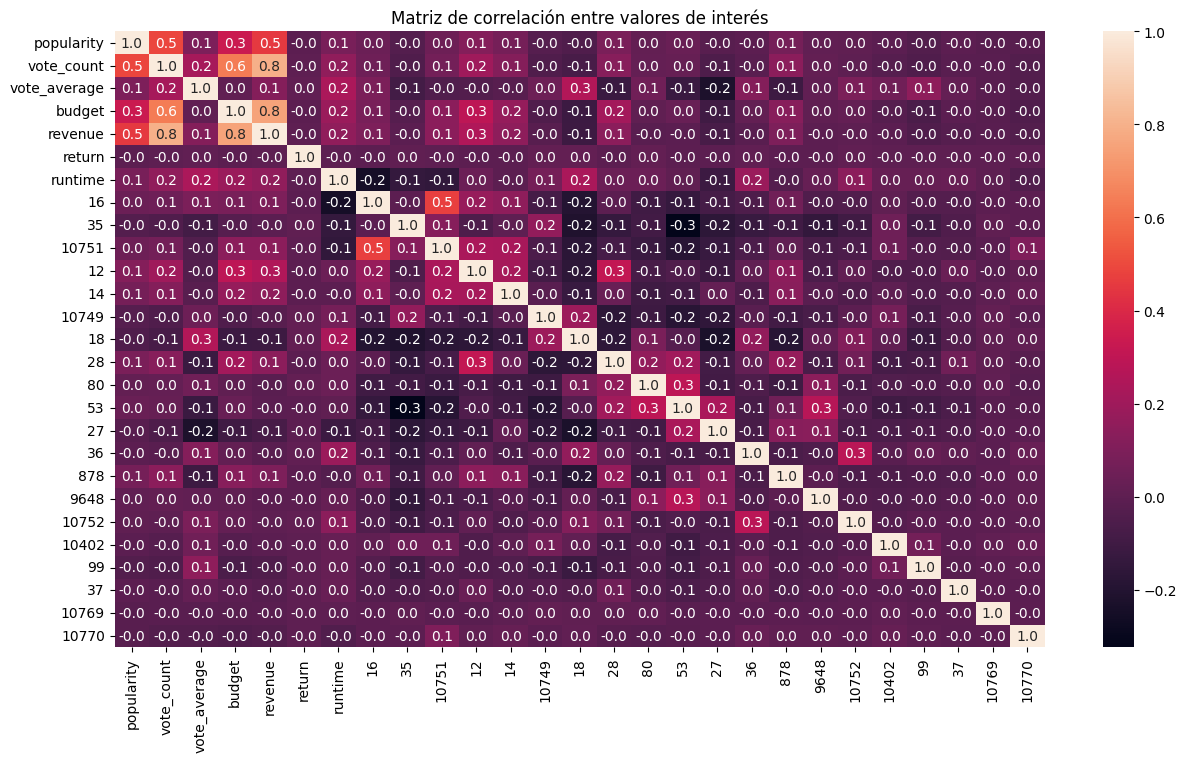

In [139]:
correlations = df_genres[["popularity", "vote_count", "vote_average", "budget", "revenue", "return", "runtime"] + genres].corr()
plt.figure(figsize=(15, 8))
sbn.heatmap(correlations, annot=True, fmt=".1f")

plt.title('Matriz de correlación entre valores de interés')

In [140]:
print("id       sum")
df_genres[genres].sum().sort_values(ascending=False)

id       sum


18       6273
35       4516
53       3440
28       2873
10749    2222
80       1810
27       1768
12       1753
878      1316
10751    1225
14       1087
9648      986
16        837
36        501
10752     425
10402     421
99        294
37        271
10770     160
10769      27
dtype: int64

Tras esto es seguro asumir que los unicos generos significativamente corelacionados son {16} Animation y {10751} Family con un coheficiente de 0.5, seguidos por relaciones de cohincidencia como History e War, o Thriller y Crime (0.3), que nos na una idea de que generos pueden considerarse similares.

Tambien vemos que no aparecen preferencias geneales entre la popularidad, votos, o ganancias e inversiones de una filmación, y sus generos.<br/>
<small>
Aunque se puede ver que si existe una relación entre la popularidad de una filmación, sus budget, revenue y la cantidad. los que nos permite reducir de esas columnas 
</small>


*Queda explorar que tipo de relacion existe entre budget y revenue, y entre estas y vote_count

budget         380000000.0
revenue       2787965087.0
vote_count         14075.0
popularity      547.488298
dtype: Float64


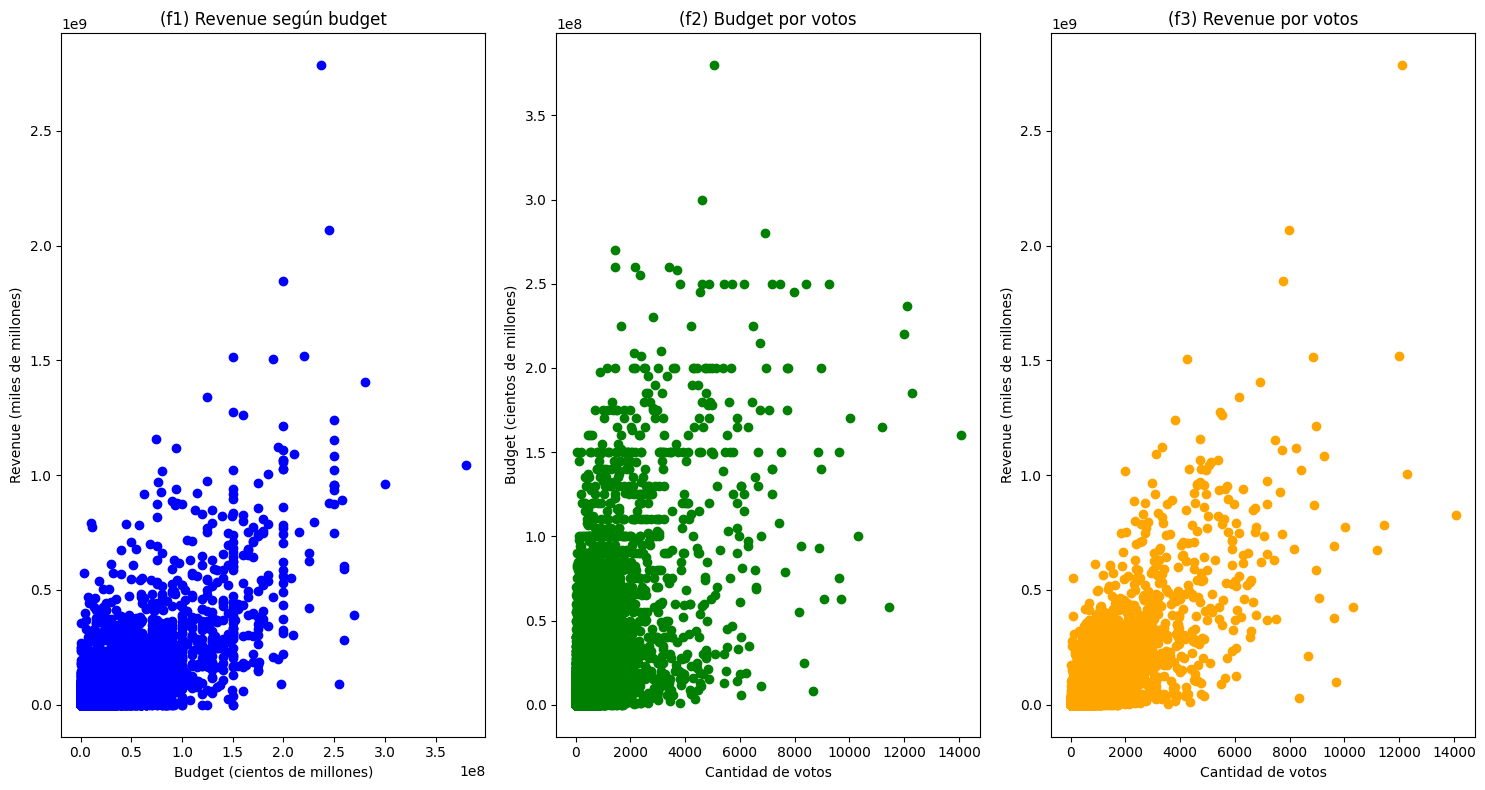

In [141]:
movies_budget_revenue = movies[["budget", "revenue", "vote_count", "popularity"]]
print(movies_budget_revenue.max())
plt.figure(figsize=(15, 8))
plt.subplot(1,3,1)
plt.scatter(movies_budget_revenue["budget"].values, movies_budget_revenue["revenue"].values, color="blue")

plt.xlabel('Budget (cientos de millones)')
plt.ylabel('Revenue (miles de millones)')
plt.title('(f1) Revenue según budget')


plt.subplot(1,3,2)
plt.scatter(movies_budget_revenue["vote_count"].values, movies_budget_revenue["budget"].values, color="green")

plt.xlabel('Cantidad de votos')
plt.ylabel('Budget (cientos de millones)')
plt.title('(f2) Budget por votos')


plt.subplot(1,3,3)
plt.scatter(movies_budget_revenue["vote_count"].values, movies_budget_revenue["revenue"].values, color="orange")

plt.xlabel('Cantidad de votos')
plt.ylabel('Revenue (miles de millones)')
plt.title('(f3) Revenue por votos')

plt.tight_layout()

Esta ultima comparación se puede ver la tendencia a tener mayor ganancia con mayor inversión (budget) <small style="font-size: 12px;">**[f1]**</small>, a tener mayor cantidad de votos con mayores ganancias  <small style="font-size: 12px;">**[f3]**</small> y la menos solida, entre la inversión (budget) y la cantidad de votos  <small style="font-size: 12px;">**[f2]**</small>

Ahora entre todas ellas y la popularidad de la filmación

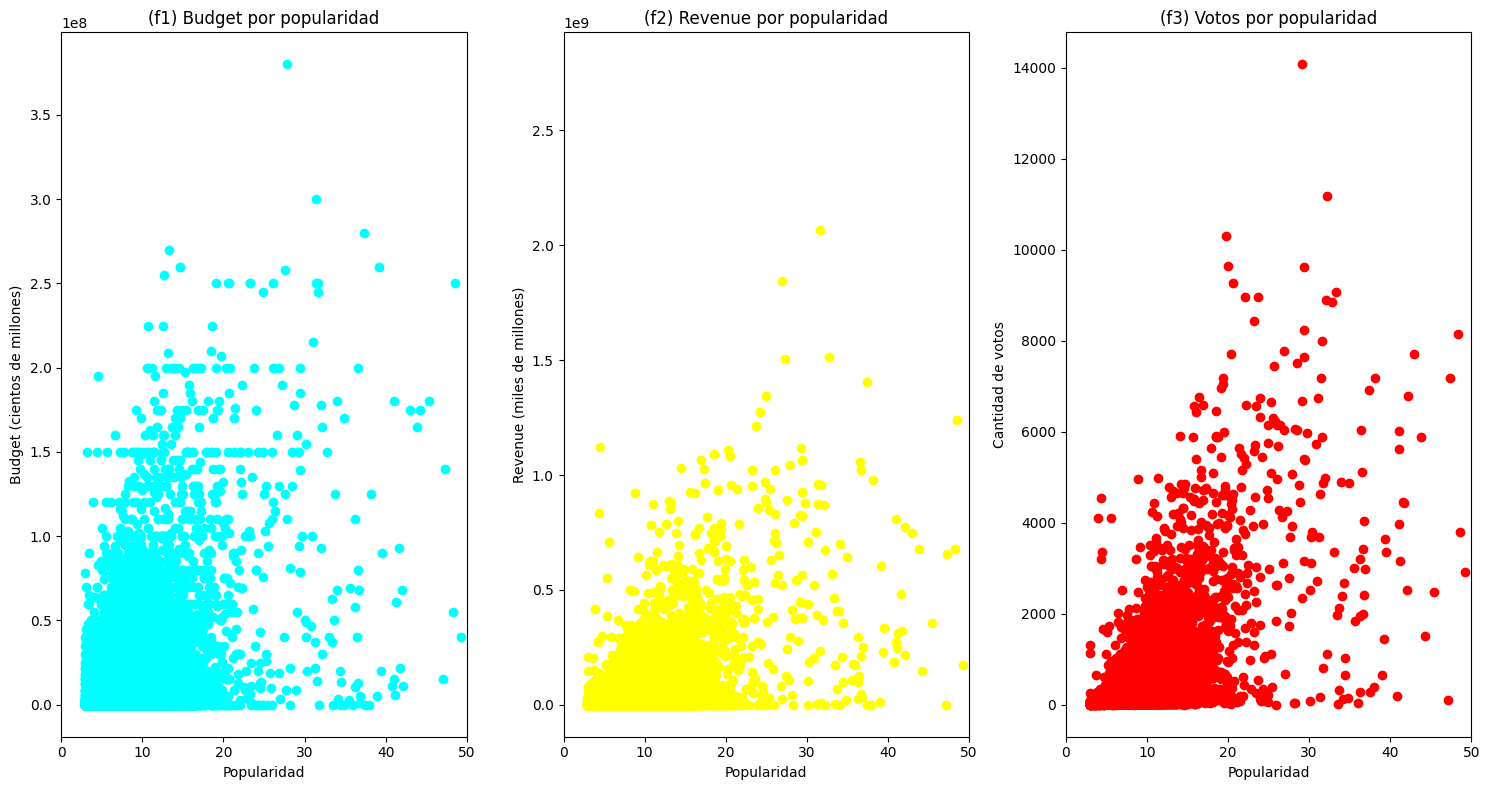

In [142]:
pop_max = 50 # limite de la grafica de popularidad para evitar confusión a causa de outliers
plt.figure(figsize=(15, 8))
plt.subplot(1,3,1)
plt.scatter(movies_budget_revenue["popularity"].values, movies_budget_revenue["budget"].values, color="cyan")

plt.xlim(left=0, right=pop_max)
plt.xlabel('Popularidad')
plt.ylabel('Budget (cientos de millones)')
plt.title('(f1) Budget por popularidad')


plt.subplot(1,3,2)
plt.scatter(movies_budget_revenue["popularity"].values,movies_budget_revenue["revenue"].values, color="yellow")

plt.xlim(left=0, right=pop_max)
plt.xlabel('Popularidad')
plt.ylabel('Revenue (miles de millones)')
plt.title('(f2) Revenue por popularidad')


plt.subplot(1,3,3)
plt.scatter(movies_budget_revenue["popularity"].values,movies_budget_revenue["vote_count"].values , color="red")

plt.xlim(left=0, right=pop_max)
plt.xlabel('Popularidad')
plt.ylabel('Cantidad de votos')
plt.title('(f3) Votos por popularidad')

plt.tight_layout()

Aqui se puede ver la tendencia a tener mayor ganancia y votos según sea mayor la popularidad <small style="font-size: 12px;">**[f2, f3]**</small> y de la misma manera pero menos evidente en el caso de la inversión (budget) <small style="font-size: 12px;">**[f1]**</small>

Dado que estas relaciones son similares a las previas, pero dependen de una sola variable, podemos tomar la variable **popularidad** como *predictora*  y/o independiente, que nos permite explicar el comportamiento de las primeras comparaciones

Por lo cual podemos separar las variables de interes en **[generos, runtime, popularidad, promedio de votos, rotorno]**
lo que debe añadirse a **[año de estreno, los lenguajes de la filmación, la colección a la que pertenece, las comapañias que la produjo, el país en que se produjo]** que son variables de similitud entre las peliculas, con el objetivo de producir un modelo de recomendación

In [143]:
pop_by_language = movies["spoken_languages"].apply(ast.literal_eval)

langs = []
for lg in pop_by_language.values:
    for l in lg:
        if l not in langs:
            langs.append(l)


In [ ]:
df_langs = movies[["popularity","spoken_languages", "original_language"]]
df_langs["spoken_languages"] = pop_by_language
for l in langs:
    df_langs[l] = 0

In [145]:
for i, row in df_langs.iterrows():
    for g in row["spoken_languages"]:
        df_langs.loc[i,g] = 1

In [146]:
df_langs.shape #Too many languages

(13051, 108)

<BarContainer object of 10 artists>

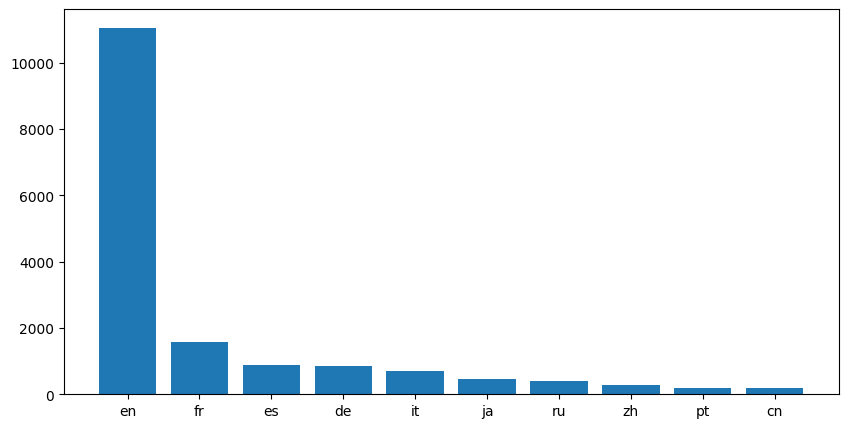

In [147]:
gf = df_langs[langs].sum().sort_values(ascending=False) # la mayoria de lenguages solo aparecen en pocas filmaciones
gf = gf[gf.values>gf.mean()] #filtramos por los lenguages mas usados
plt.figure(figsize=(10, 5))
plt.bar(gf.index, gf.values)

Para otros lenguajes los introducimos en la categoria other_lang

In [148]:
df_langs["other_lang"] = 0
langs = list(gf.index) + ["other_lang"]

C:\Users\Jorge Schimpf\AppData\Local\Temp\ipykernel_1224\2432452409.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_langs["other_lang"] = 0


In [149]:
df_langs = df_langs[["popularity"] + langs]
for i, row in df_langs[langs].iterrows():
    if row[langs].sum()==0:
        df_langs.loc[i,"other_lang"] = 1

df_langs

,popularity,en,fr,es,de,it,ja,ru,zh,pt,cn,other_lang
id,,,,,,,,,,,,
862,21.946943,1,0,0,0,0,0,0,0,0,0,0
8844,17.015539,1,1,0,0,0,0,0,0,0,0,0
15602,11.712900,1,0,0,0,0,0,0,0,0,0,0
31357,3.859495,1,0,0,0,0,0,0,0,0,0,0
11862,8.387519,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
432789,5.667067,1,0,0,0,0,0,0,0,0,0,0
434873,8.471866,1,0,0,0,0,0,0,0,0,0,0
455661,20.821780,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
ml_df = movies[["popularity", "return", "vote_average", "release_year", "runtime", "belongs_to_collection", "production_companies", "production_countries"]]
ml_df[genres] = df_genres[genres]
ml_df[langs] = df_langs[langs]
ml_df.head()

In [156]:
ml_df.sort_index(inplace=True)

In [157]:
ml_df.to_csv("datasets/ml_encoded_data.csv")